In [5]:
import json
import requests

import torch
import torch.nn as nn
import torch.optim

import re
import jieba
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

In [6]:
# 不用自己下载，直接使用已下载好的数据，在目录 emotion_classifier_data/
def get_comments(url):
    comments = []
    resp = requests.get(url)
    resp.encoding = 'gbk'

    if resp.status_code != 200:
        return []

    content = resp.text
    if content:
        ind = content.find('(')
        s1 = content[ind + 1 : -2]
        try:
            js = json.loads(s1)
            comment_infos = js['comments']
        except:
            print('error')
            return([])

        for comment_info in comment_infos:
            comment_content = comment_info['content']
            str1 = comment_content + '\n'
            comments.append(str1)
    return comments

good_comments = []
good_comment_url_templates = [
]

j = 0
for good_comment_url_template in good_comment_url_templates:
    # 模拟翻页100次
    for i in range(100):
        url = good_comment_url_template.format(i)
        good_comments += get_comments(url)
        print('第 {} 条记录，总文本长度: {}'.format(j, len(good_comments)))
        j += 1

# fw = open('data/good.txt', 'w', encoding = 'utf-8')
# fw.writelines(good_comments)

In [25]:
good_file = '04_emotion_classifier_data/good.txt'
bad_file = '04_emotion_classifier_data/bad.txt'

def filter_punc(sentence):
    sentence = re.sub("[\\s+\\.\\!\\/_,$%^*(+\\\"\\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)
    return(sentence)

def prepare_data(good_file, bad_file, is_filter=True):
    all_words = []
    pos_sentences = []
    neg_sentences = []
    with open(good_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            words = jieba.lcut(line) # 分词
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} include {1} lines, {2} words.'.format(good_file, idx +  1, len(all_words)))

    count = len(all_words)
    with open(bad_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            words = jieba.lcut(line) # 分词
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} include {1} lines, {2} words.'.format(bad_file, idx +  1, len(all_words) - count))

    # 建立词典: word -> [id, 频率]
    diction = {}
    cnt = Counter(all_words) # 统计频率
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('diction size: {}'.format(len(diction)))
    return (pos_sentences, neg_sentences, diction)
            
pos_sentences, neg_sentences, diction = prepare_data(good_file, bad_file, True)
st = sorted([(v[1], w) for w, v in diction.items()])

def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return value

def index2word(index, diction):
    for w, v in diction.items():
        if v[0] == index:
            return w
    return None

emotion_classifier_data/good.txt include 8089 lines, 100839 words.
emotion_classifier_data/bad.txt include 5076 lines, 56070 words.
diction size: 7135


In [8]:
print(word2index('不错', diction))
print(index2word(13, diction))

13
不错


In [9]:
# 句子的向量化
# 向量的尺寸是词典中词汇的个数，i位置上的数值为第i个单词出现的频率
def sentence2vec(sentence, dictionary):
    vector = np.zeros(len(dictionary))
    for l in sentence:
        vector[l] += 1
    return 1.0 * vector / len(sentence)  # 压缩到0~1之间

dataset= []
labels = []
sentences = [] # 原始句子，调试用 

#  处理正向评论
for sentence in pos_sentences:
    new_sentence_index = []
    for l in sentence: # 已经分词了
        if l in diction:
            new_sentence_index.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence_index, diction))
    labels.append(0) # 0代表正标签
    sentences.append(sentence)

#  处理负向评论
for sentence in neg_sentences:
    new_sentence_index = [] 
    for l in sentence: # 已经分词了
        if l in diction:
            new_sentence_index.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence_index, diction))
    labels.append(1) # 1代表负标签
    sentences.append(sentence)

indices = np.random.permutation(len(dataset))
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]
print(len(dataset[0]))
print(dataset[0][30:128])
print(sentences[0])

7135
[0.         0.         0.         0.         0.         0.
 0.11111111 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
['这是', '什么', '鬼', '和', '图片'

In [10]:
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

validate_data = dataset[: test_size]
validate_label = labels[: test_size]

test_data = dataset[test_size: 2 * test_size]
test_label = labels[test_size: 2 * test_size]

print(len(validate_data))

1303


In [11]:
# 构建神经网络
m = nn.ReLU()
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(), # max(0,x)
    nn.Linear(10, 2),
    nn.LogSoftmax(dim=1), # dim=1按照第二个维度计算输出，也就是输出每一个样本在各个类别的概率
)

# 计算分类准确度
def rightness(predictions, labels):
    # max函数返回[value, index], pred得到最大概率的索引，0表示好，1表示负面
    pred = torch.max(predictions.data, 1)[1] # max的dim=1 表示沿着第二个维度计算max，即好或坏两个分类数值， 

    rights = pred.eq(labels.data.view_as(pred)).sum()

    return rights, len(labels)

# 对于分类问题 损失函数为交叉熵
cost = nn.NLLLoss()
# 优化器，自动调节学习率
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
records = []

losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = torch.FloatTensor(x).view(1, -1) #[1, len(diction)]
        y = torch.LongTensor(np.array([y])) #[1,1]

        optimizer.zero_grad(); # 清空梯度
        predict = model(x) 
        loss = cost(predict, y)

        losses.append(loss.data.numpy())

        loss.backward() # 梯度反向传播
        optimizer.step() # 开始对参数进一步优化

        # 运行校验集的数据，只是验证结果，不能反向传播梯度参与训练
        if i % 3000 == 0:
            val_losses = []
            rights = []
            for j, val in enumerate(zip(validate_data, validate_label)):
                x, y = val
                x = torch.FloatTensor(x).view(1, -1) #[1, len(diction)]
                y = torch.LongTensor(np.array([y])) #[1,1]

                predict = model(x)
                right = rightness(predict, y) # 计算准确度
                rights.append(right)
                
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy())
            # 计算校验集的平均准确度
            right_ratio = 1.0 * np.sum(np.fromiter((i[0] for i in rights), int)) / np.sum(np.fromiter((i[1] for i in rights), int))

            print('第 {} 轮，训练损失: {:.2f}，校验损失: {:.2f}，校验准确率: {:.2f}'
                  .format(epoch, np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

第 0 轮，训练损失: 0.67，校验损失: 0.69，校验准确率: 0.61
第 0 轮，训练损失: 0.67，校验损失: 0.67，校验准确率: 0.61
第 0 轮，训练损失: 0.66，校验损失: 0.64，校验准确率: 0.61
第 0 轮，训练损失: 0.64，校验损失: 0.55，校验准确率: 0.84
第 1 轮，训练损失: 0.62，校验损失: 0.51，校验准确率: 0.84
第 1 轮，训练损失: 0.59，校验损失: 0.44，校验准确率: 0.85
第 1 轮，训练损失: 0.56，校验损失: 0.40，校验准确率: 0.87
第 1 轮，训练损失: 0.53，校验损失: 0.37，校验准确率: 0.86
第 2 轮，训练损失: 0.52，校验损失: 0.37，校验准确率: 0.87
第 2 轮，训练损失: 0.51，校验损失: 0.37，校验准确率: 0.85
第 2 轮，训练损失: 0.49，校验损失: 0.34，校验准确率: 0.88
第 2 轮，训练损失: 0.48，校验损失: 0.34，校验准确率: 0.88
第 3 轮，训练损失: 0.47，校验损失: 0.33，校验准确率: 0.88
第 3 轮，训练损失: 0.46，校验损失: 0.35，校验准确率: 0.86
第 3 轮，训练损失: 0.45，校验损失: 0.32，校验准确率: 0.89
第 3 轮，训练损失: 0.44，校验损失: 0.32，校验准确率: 0.89
第 4 轮，训练损失: 0.44，校验损失: 0.31，校验准确率: 0.89
第 4 轮，训练损失: 0.43，校验损失: 0.34，校验准确率: 0.87
第 4 轮，训练损失: 0.42，校验损失: 0.31，校验准确率: 0.89
第 4 轮，训练损失: 0.41，校验损失: 0.31，校验准确率: 0.90
第 5 轮，训练损失: 0.41，校验损失: 0.30，校验准确率: 0.89
第 5 轮，训练损失: 0.41，校验损失: 0.33，校验准确率: 0.87
第 5 轮，训练损失: 0.40，校验损失: 0.30，校验准确率: 0.89
第 5 轮，训练损失: 0.40，校验损失: 0.30，校验准确率: 0.90
第 6 轮，训练损失: 0.39，校验损失: 0.30，校验准确率: 0.90


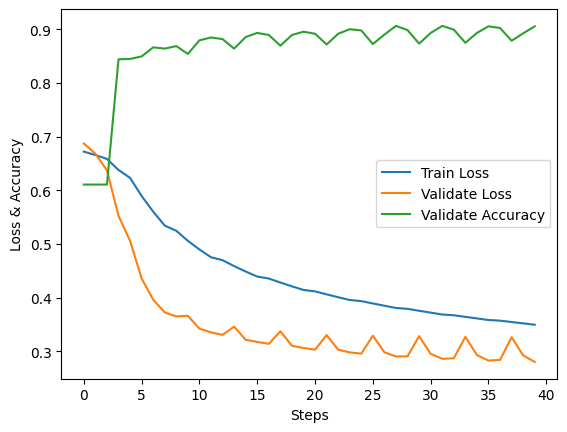

In [12]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Validate Loss')
plt.plot(c, label = 'Validate Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()
plt.show()

In [13]:
# 在测试集上运行
vals = []
for data, target in zip(test_data, test_label):
    data = torch.FloatTensor(data).view(1, -1) #[1, len(diction)]
    target = torch.LongTensor(np.array([target])) #[1,1]
    
    ouptput = model(data)
    val = rightness(ouptput, target) # 计算准确度
    vals.append(val)

rights = (sum(tup[0] for tup in vals), sum(tup[1] for tup in vals))
right_ratio = 1.0 * rights[0] / rights[1]
print("the right ratio of test dataset: ", right_ratio)

the right ratio of test dataset:  tensor(0.9071)


In [14]:
# 打印神经网络架构， 打印结果每个运算前面的数字可以用来组合成model[i] 访问各层的权重
model.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Linear(in_features=7135, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)>

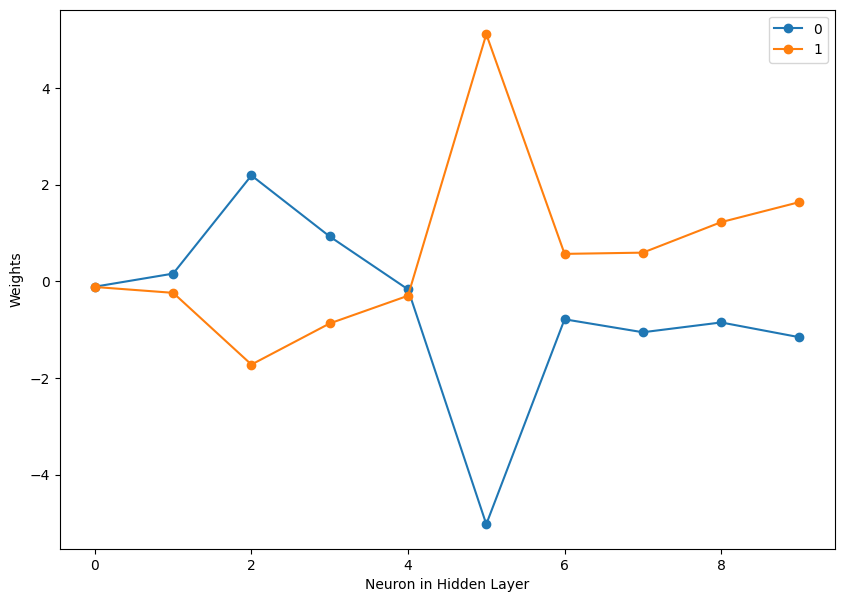

In [15]:
# 打印隐含层到输出层节点的权重
plt.figure(figsize=(10, 7))

# weight结构为 2 * 10
for i in range(model[2].weight.size()[0]):
    weights = model[2].weight[i].data.numpy()
    plt.plot(weights, 'o-', label = i)
    plt.legend()
    plt.xlabel('Neuron in Hidden Layer')
    plt.ylabel('Weights')

Text(0, 0.5, 'Weights')

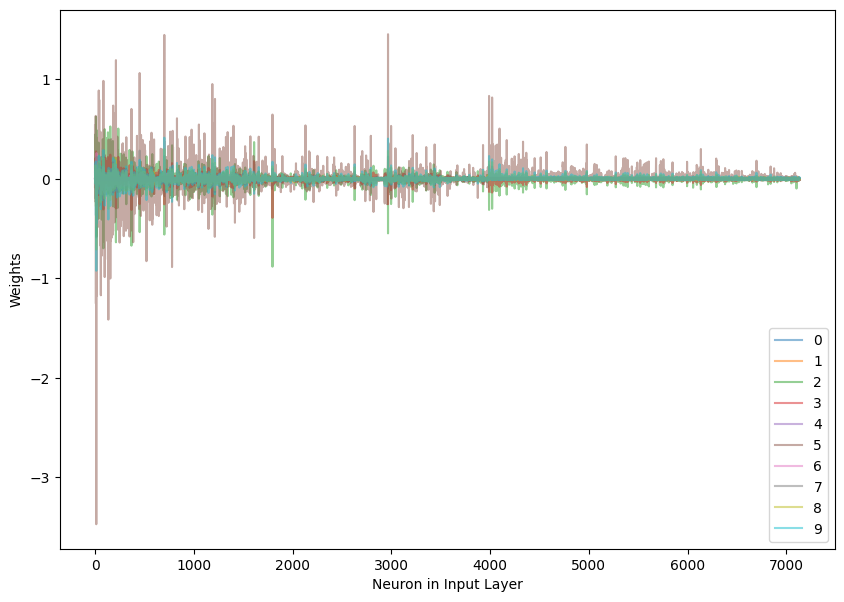

In [16]:
# 输入层到隐含层的权重
plt.figure(figsize = (10, 7))
for i in range(model[0].weight.size()[0]):
    weights = model[0].weight[i].data.numpy()
    plt.plot(weights, alpha = 0.5, label = i)
plt.legend()
plt.xlabel('Neuron in Input Layer')
plt.ylabel('Weights')

In [17]:
# 输出输入层到隐含层最大或最小权重对应的单词
# 对应隐藏层的10个神经元
for i in range(len(model[0].weight)):
    print('\n第 {} 个神经元'.format(i))
    st = sorted([(w, i) for i, w in enumerate(model[0].weight[i].data.numpy())])

    print('max: ', end='')
    # 权重最大的20个词
    for i in range(1, 21):
        word = index2word(st[-i][1], diction)
        print(word, end=', ')

    print('\nmin: ', end='')
    for i in range(1, 21):
        word = index2word(st[i][1], diction)
        print(word, end=', ')
    print('\n')



第 0 个神经元
max: 相比, 三天, 图饰, 很细, 几, 刺刺, 整逼, 张安住, 真京, 不, 感觉良好, 这间, lsquo, 打劫, 标给, 一灰一, 体恤, 一定, 没到, 刮痕, 
min: 丑爆, 穿后, 180, 左, 人一扯, 开玩笑, 同样, 骗子, 试一试, 满意度, 徐, 粗茶淡饭, 买不到, 裂开来, 刚回来, 上吊, 实在, 开个, 合体, 洗出, 


第 1 个神经元
max: 上, 物美价廉, ⊙, 喜欢, 差太远, 风光, 传说, 黄点, 很赞, 太多人, 情愿, 缺陷, 太大有, 媳妇, 烂烂, 压, 好像, 挺快, 填, 好个屁, 
min: 轻盈, 对不上, 干得, 安全, 较, 经拆包, 色彩, 呀, T, 三块, 买来, 扯, 看得, 拿货, 女士, 衣服, 减肥, 严重, 取, 不再, 


第 2 个神经元
max: 的, 好评, 下次, 哦, 挺, 起来, 买, 价格, 喜欢, 很快, 合身, quot, 了, 知道, 收到, 快, 谢谢, 试穿, 好看, 挺舒服, 
min: 不, 不好, 不是, 还, 差, 差评, 不怎么, 质量, 没有, 一般, 不值, 很差, 不行, 差劲, 东西, 吧, 太慢, 太, 颜色, 货, 


第 3 个神经元
max: 的, 好评, 挺, 下次, 起来, 哦, 买, 喜欢, 很快, 价格, quot, 合身, 知道, 了, 快, 收到, 谢谢, 好看, 试穿, 物美价廉, 
min: 不好, 不, 不是, 还, 差, 差评, 不怎么, 质量, 不值, 一般, 没有, 慢, 差劲, 太慢, 不行, 很差, 东西, 很, 颜色, 太, 


第 4 个神经元
max: 不, 好评, dfgsdfgsvdfgsdfgsdf, 0000000000000000000000, 夏天, 风风火火, 果然, 冬装, 一份, 咯, 呃, 基本, 相当, 买, 打一看, 拆开, 额额, 感到, 上身, 高, 
min: 穿, 个, 发错, 裤子, 失望, 感觉不好, V, 来到, 这办, 某洗, 实事求是, 站立, 七十八, 失去, 离胶, 说太多, 很差, 肥皂水, 准穿, 店真, 


第 5 个神经元
max: 差评, 差, 不是, 不怎么, 不, 不值, 没有, 很差, 差劲,

In [43]:
# 收集在测试集中判断错误的句子
wrong_sentences = []
targets = []
j = 0
sent_indices = []

for data, target in zip(test_data, test_label):
    predictions = model(torch.FloatTensor(data).view(1, -1))
    pred = torch.max(predictions.data, 1)[1] # 分类的最大概率的索引， 0或1
    target = torch.LongTensor(np.array([target])).view_as(pred)
    
    rights = pred.eq(target)  # 相等的返回1
    indices = np.where(rights.numpy() == 0)[0]  # 此处过滤出不相等的， 即预测错误的
    for i in indices:
        wrong_sentences.append(data)
        targets.append(target[i])
        sent_indices.append(test_size + j + i) # test_size前面是验证集
    j += len(target)

idx = 0
# 打印分词后的原始错误句子， 保留了单词顺序
print(sentences[sent_indices[idx]], targets[idx].numpy())  # 

# 打印错误的句子的单词，单词
lst = list(np.where(wrong_sentences[idx]>0)[0]) # 该错误句子对应的单词索引
mm = list(map(lambda x: index2word(x, diction), lst))
print(mm)

['真心', '还', '不错', '值得', '购买'] 1
['不错', '还', '值得', '购买', '真心']


In [44]:
# 观察第一层的权重 与 当前输入向量的内积， 也就是对隐含层神经元的输入
# 最大数值对应的项就是被激活的神经元，负值最小的神经元就是被抑制的神经元
model[0].weight.data.numpy().dot(wrong_sentences[idx].reshape(-1, 1))

array([[-3.95034958e-03],
       [ 2.93675524e-03],
       [-3.81142192e-02],
       [-1.98489457e-02],
       [-8.34695529e-06],
       [-9.67867151e-01],
       [-6.60599634e-02],
       [-1.04376959e-01],
       [-1.94312605e-01],
       [-2.73125953e-01]])